In [1]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from scipy import integrate
import torch
import pickle
import random

/home/dogger/miniconda3/envs/ttk29/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


![title](./aluminiumextraction.jpg)

In [2]:
#X[0]:m_sl #X[1]:m_al2o3 #X[2]:m_alf3 #X[3]:m_cry #X[4]:m_metal #X[5]:T_bath #X[6]:T_sl #X[7]:T_wall
#U[0]: Alumina feed #U[1]: I_line #U[2]: AlF3 feed #U[3]: Metal Tapping #U[4]: h_acd - Interpolar distance

# Simulator constants

In [3]:
ksl = 2.5 #1.07
kwall = 6.5 #4.5
xwall = 0.1 #0.05

h_bsl = 1200
h_w0 = 25 #15

k0 = 2*10**-5 
k1 = 2*ksl*17.92/119495      #3.1*10**-4  #2*ksl*Asl/delta_fus_H_cry = (2*1.07*17.92)/119495 = 3.2*10**-4
k2 = h_bsl*17.92/119495      #0.18        #h_b-sl*A_sl/delta_fus_H_cry = 1200*17.92/119495 = 0.17996
k3 = 1.7*10**-7              #0.002*101.96*0.95/(96485.33*12) = 1.673*10**-7
k4 = 0.02
k5 = 0.03
k6 = 4.43*10**-8             #CE*0.002*26.98/(12*96485) = 4.4275*10**-8
k7 = k2*1881                 #k2*cp_cry_liq = 0.17996*1881 = 338.5
k8 = k1*1881                 #k1*cp_cry_liq = 3.2*10**-4*1881 = 0.602
k9 = 17.92                   #A_sl =17.92
k10 = 1/h_bsl                #0.0008      #1/h_b_sl = 1/1200 = 8.33*10**-4
k11 = 1/(2*ksl)              #0.47            # 1/2*ksl =0.4673
k12 = k2*1320                #k2*cp_cry_s = 0.18*1320 = 237.6
k13 = k1*1320                #k1*cp_cry_s = 3.2*10**-4*1320=0.4224 
k14 = xwall/(2*kwall)        #5.556*10**-3           #xwall/2*k_wall = 0.05/2*4.5 = 5.556*10**-3
k15 = 1/(2*ksl)              #0.4673                 #1/2ksl  =1/2*1.07 = 0.4673
k16 = 38.4     #NOT USED  2*ksl*Asl = 38.35 
k17 = 6*10**-7       
k18 = k9       #NOT USED     k9=k18
k19 = 35                      #T0 = 35deg
k20 = 1/h_w0                 #0.0667 #1/h_w_0 = 1/15 = 0.0667
alpha = 5.66*10**-4          #1/cp_bath_l = 1/1767 = 5.66*10**-4
beta = 7.58*10**-4           #1/cp_cry_s = 7.58*10**-4

In [4]:
x = ca.SX.sym('x',8)
u = ca.SX.sym('u',5)

c_x1 =x[1]/(x[1]+x[2]+x[3])
c_x2 = x[2]/(x[1]+x[2]+x[3])

pr_x1_crit = 2.2
pr_x1 = 100*c_x1
pr_x2 = 100*c_x2

#----------------------------------------------------------------------------
#Nonlinear help functions
#----------------------------------------------------------------------------
g1 = 991.2 + 1.12*pr_x2 - 0.13*pr_x2**2.2 + 0.061*pr_x2**1.5- 7.93*pr_x1/(1 + 0.0936*pr_x2 - 0.0017*pr_x2**2 - 0.0023*pr_x2*pr_x1)
g2 = np.exp(2.496 - 2068.4/(273+x[5]) - 2.07*c_x1)
g3 = 0.531 + 6.958*10**-7*u[1] - 2.51*10**-12*u[1]**2 + 3.06*10**-18*u[1]**3+ (0.431 - 0.1437*(pr_x1 - pr_x1_crit))/(1 + 7.353*(pr_x1 - pr_x1_crit))
g4 = (0.5517 + 3.8168*10**-6*u[1])/(1 + 8.271*10**-6*u[1])
g5 = (3.8168*10**-6*g3*g4*u[1])/(g2*(1-g3))

#----------------------------------------------------------------------------
#Set of ODE's
#----------------------------------------------------------------------------
xdot_1 = k1*(g1 - x[6])/(k0*x[0]) - k2*(x[5] - g1)
xdot_2 = u[0] - k3*u[1]
xdot_3 = u[2] - k4*u[0]
xdot_4 = -(k1*(g1 - x[6])/(k0*x[0]) - k2*(x[5] - g1)) + k5*u[0]
xdot_5 = k6*u[1] - u[3]
xdot_6 = alpha/(x[1] + x[2] + x[3])*(u[1]*(g5 + u[1]*u[4]/(2620*g2)) - k9*(x[5] - x[6])/(k10 + k11*k0*x[0])\
                                    -(k7*(x[5] - g1)**2 - k8*(x[5] - g1)*(g1 - x[6])/(x[0]*k0))) 
xdot_7 = beta/x[0]*(k9*(g1 - x[6])/(k15*k0*x[0]) - k9*(x[6] - x[7])/(k14 + k15*k0*x[0])\
                    - (k12*(x[5] - g1)*(g1 - x[6]) - k13*(g1 - x[6])**2/(x[0]*k0))) 
xdot_8 = k17*(k9*(x[6] - x[7])/(k14 + k15*k0*x[0]) - k9*(x[7] - k19)/(k14 + k20))

xdot = ca.vcat([xdot_1, xdot_2, xdot_3, xdot_4, xdot_5, xdot_6, xdot_7,xdot_8])

#----------------------------------------------------------------------------
#Set of ODE's:
#----------------------------------------------------------------------------
f = ca.Function('ca_nonlin_fun', [x,u],[xdot])

# Runge Kutta 4
M=1   
X0 = ca.MX.sym('X0', 8)
U = ca.MX.sym('U',5)
X = X0 #init values
Delta_T = ca.MX.sym('DT',1)

for j in range(M):
    c1 = f(X, U)
    c2 = f(X + Delta_T/2 * c1, U)
    c3 = f(X + Delta_T/2 * c2, U)
    c4 = f(X + Delta_T * c3, U)
    X=X+Delta_T/6*(c1 +2*c2 +2*c3 +c4)

RK4 = ca.Function('RK4', [X0, U, Delta_T], [X],['x0','u', 'DT'],['xf'])

In [5]:
#----------------------------------------------------------------------------
#Controllers
def al2o3_feed(x2,x3,x4,DT):
    c_al2o3 = x2/(x2+x3+x4)
    K = 30000
    u = np.max((K*(0.023 - c_al2o3),0))
    if u<(140/DT):
        u=0
        return u
    u = np.min((u,220/DT))
    return u

#def rand_al2o3_feed(x2,x3,x4):
    c_al2o3 = x2/(x2+x3+x4)
    K = 30000
    u = np.max((K*(0.0215 - c_al2o3),0))
    if u<(140/DT):
        u=0
        return u
    u = np.min((u,220/DT))
    return u

def alf3_feed(x2,x3,x4,DT):
    c_alf3 = x3/(x2+x3+x4)
    K = 13000
    u = np.max((K*(0.105-c_alf3),0))
    if u<(20/DT):
        u = 0
        return u
    u = np.min((u,80/DT))
    return u

def metal_tap(x5,DT):
    K=300
    u = np.max((K*(x5-10000),0))
    if u<20/DT:
        u=0
        return u
    u = np.min((u, (90/DT)))
    return u

In [6]:
def simulate_system(x0, u0, DT, n_sim_steps, mode):

    if mode !='oper' and mode!= 'random':
        raise Exception('Mode must be either oper or random')
    
    rand_u0 = 0.0
    rand_u1 = 0.0
    rand_u2 = 0.0
    rand_u3 = 0.0
    rand_u4 = 0.0


    X = torch.empty(n_sim_steps, 13)
    
    
    X[0,:] = torch.from_numpy(np.concatenate([x0, u0], axis=0))
    
    x = np.zeros(8)
    x[:] = x0[:]
    
    u = np.zeros(5)
    u[:] = u0[:]
    

    i_alf3 = torch.zeros(2)
    i_alf3[1] = random.randint(120,250)
    

    ind_ps_rand_u0 = random.randint(100,1100)
    prev_i_u0 = 0

    ind_ps_rand_u2 = random.randint(100,1100)
    prev_i_u2 = 0

    ind_ps_rand_u3 = random.randint(100,1100)
    prev_i_u3 = 0
    
    ind_ps_rand_u1 = random.randint(100,1100)
    prev_i_u1 = 0
    ind_ps_rand_u4 = random.randint(100,1100)
    prev_i_u4 = 0
    
    for i in range(1, n_sim_steps):
        
        #Next value of x given previous state x and input u
        x = RK4(x,u, DT)
        
        x = x.full()[:,0]
        
        u[0] = 0
        u[2] = 0
        u[3] = 0

        if mode =='oper':
            # Alumina feed
            u[0] = al2o3_feed(x[1], x[2], x[3], DT)
            
            #Line current, fluctating to generate variations in dataset
            u[1] = u0[1] + 2000*np.sin(i*0.01)

            #Aluminum fluoride feed
            u[2] = alf3_feed(x[1], x[2], x[3], DT)
            
            # Metal tapping
            u[3] = metal_tap(x[4], DT)
            
            #Anode-cathode distance
            u[4] = u0[4] + 0.005*np.cos(i*0.1)
        elif mode=='random':
            

            #Standard APRBS
            # ------------------------------------------
            if i%(prev_i_u1 + ind_ps_rand_u1)==0: #140
                
                #Line current
                prev_i_u1 = i
                rand_u1 = float(random.randint(- 22000,15000)) #(- 10000,10000)
                ind_ps_rand_u1 = random.randint(100,1100)

            if i%(prev_i_u4 + ind_ps_rand_u4)==0: #210
                #ACD
                prev_i_u4 = i
                rand_u4 = float(random.randint(-70,70)/10000) #(-50,50)
                ind_ps_rand_u4 = random.randint(100,1100)
            # ------------------------------------------
            #Impulse APRBS
            # ------------------------------------------
            if i%(prev_i_u0 + ind_ps_rand_u0)==0:
                prev_i_u0 = i
                rand_u0 = float(random.randint(100,2000)/100.0)
                ind_ps_rand_u0 = random.randint(500,2000)
            
            if i%(prev_i_u2 + ind_ps_rand_u2)==0:
                prev_i_u2 = i
                rand_u2 = float(random.randint(100,1000)/100.0)
                ind_ps_rand_u2 = random.randint(1000,3000)

            if i%(prev_i_u3 + ind_ps_rand_u3)==0:
                prev_i_u3 = i
                rand_u3 = float(random.randint(100,1000)/100.0)
                ind_ps_rand_u3 = random.randint(200,1100)
        
            #Alumina
            u[0] = al2o3_feed(x[1], x[2], x[3], DT) + rand_u0
            rand_u0 = 0
          
            #Line current, fluctating to generate variations in dataset
            u[1] = u0[1] + rand_u1

            # AlF3  
            u[2] = alf3_feed(x[1], x[2], x[3], DT) + rand_u2
            rand_u2 = 0

            u[3] = metal_tap(x[4], DT) # + rand_u3
            
            #Anode-cathode distance
            u[4] = u0[4] + rand_u4


        X[i,:] = torch.cat([torch.from_numpy(x), torch.from_numpy(u)])
        

    return X

In [7]:
def generate_random_initializations(x_range, n_sim, DT):
    #Input:
    #   x_range: 2x8 dim np array, upper and lower bound of each variable
    #       - x_range[:,1] and x_range[:,2] come in % of total mass
    #        
    #   n_sim:  no. of initial conditions to generate
    #   DT: sampling time
    #
    #Output:
    #   x_init: n_sim x 8 dim np array - n_sim init conditions of all variables
    #   u_init n_sim x 5 dim np array - n_sim init conditions of all inputs
    
    x_init = np.zeros((n_sim, 8))
    u_init = np.zeros((n_sim, 5))
    
    for i in range(n_sim):
        frac_m1 = float(random.randint(x_range[0,1],x_range[1,1])/100)
        frac_m2 = float(random.randint(x_range[0,2],x_range[1,2])/100)
        m3 = float(random.randint(x_range[0,3],x_range[1,3]))
        for j in range(8):
            if j==1:
                a = frac_m1*m3
                b = frac_m1*frac_m2*m3/(1-frac_m2)
                c = frac_m1*frac_m2/(1-frac_m2)
                m1 = (a+b)/(1-frac_m1-c)
                x_init[i,j] = m1
            elif j==2:
                x_init[i,j] = frac_m2*(m1 + m3)/(1 - frac_m2)
            elif j==3:
                x_init[i,j] = m3
            else:
                x_init[i,j] = float(random.randint(x_range[0,j], x_range[1,j]))

        for j in range(5):
            if j==0:
                u_init[i,j] = al2o3_feed(x_init[i,1], x_init[i,2], x_init[i,3], DT)
            if j==1:
                u_init[i,j] = 140000
            if j==2:
                u_init[i,j] = alf3_feed(x_init[i,1], x_init[i,2], x_init[i,3],DT)
            if j==3:
                u_init[i,j] = metal_tap(x_init[i,4],DT)
            if j==4:
                u_init[i,j] = 0.05
                
    return x_init, u_init

In [8]:
def generate_dataset(x_range, n_sim, name, n_sim_steps, DT, mode='oper'):
    #Input:
    #   x0_vec: nx8 dim np array with initial conditions for 8 states and n different simulations
    #   u0_vec: nx5 dim np array with initial conditions for 5 inputs and 
    #   name: string with name of pickle file
    
    #Var:
    #   data: nxkx13 dim torch.tensor: 
    #       n - no. of simulations
    #       k - no. of simulation steps in each simulation
    #       13 - no of variables (8 states and 5 inputs)
    
    x0_vec, u0_vec = generate_random_initializations(x_range, n_sim, DT)

    n = x0_vec.shape[0]
    k = n_sim_steps
    
    data = torch.empty(n, k, 13)

    for i in range(n):
        data[i,:,:]= simulate_system(x0_vec[i,:], u0_vec[i,:], DT, n_sim_steps, mode)

        while torch.isnan(data[i,:,:]).any():
            print('Simulation number %d failed, trying again', i)
            #new_x0 =generate_random_initializations(x_range, 1)
            data[i,:,:] = simulate_system(x0_vec[i,:], u0_vec[i,:],DT, n_sim_steps, mode)
        print(f'Simulation number {i} succeeded')
     
    filename = name + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle)



In [9]:
x_range = np.array([[2060,4460], [2,5], [9,13], [11500,16000],[9750,10000],[960,990], [790,850],[555,610]])
x_range = x_range.T
generate_dataset(x_range,n_sim=10, name='PBM_simulation_data',n_sim_steps=100000, DT=10, mode='random')

Simulation number 0 succeeded
Simulation number 1 succeeded
Simulation number 2 succeeded
Simulation number 3 succeeded
Simulation number 4 succeeded
Simulation number 5 succeeded
Simulation number 6 succeeded
Simulation number 7 succeeded
Simulation number 8 succeeded
Simulation number 9 succeeded


In [14]:
with open('PBM_simulation_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

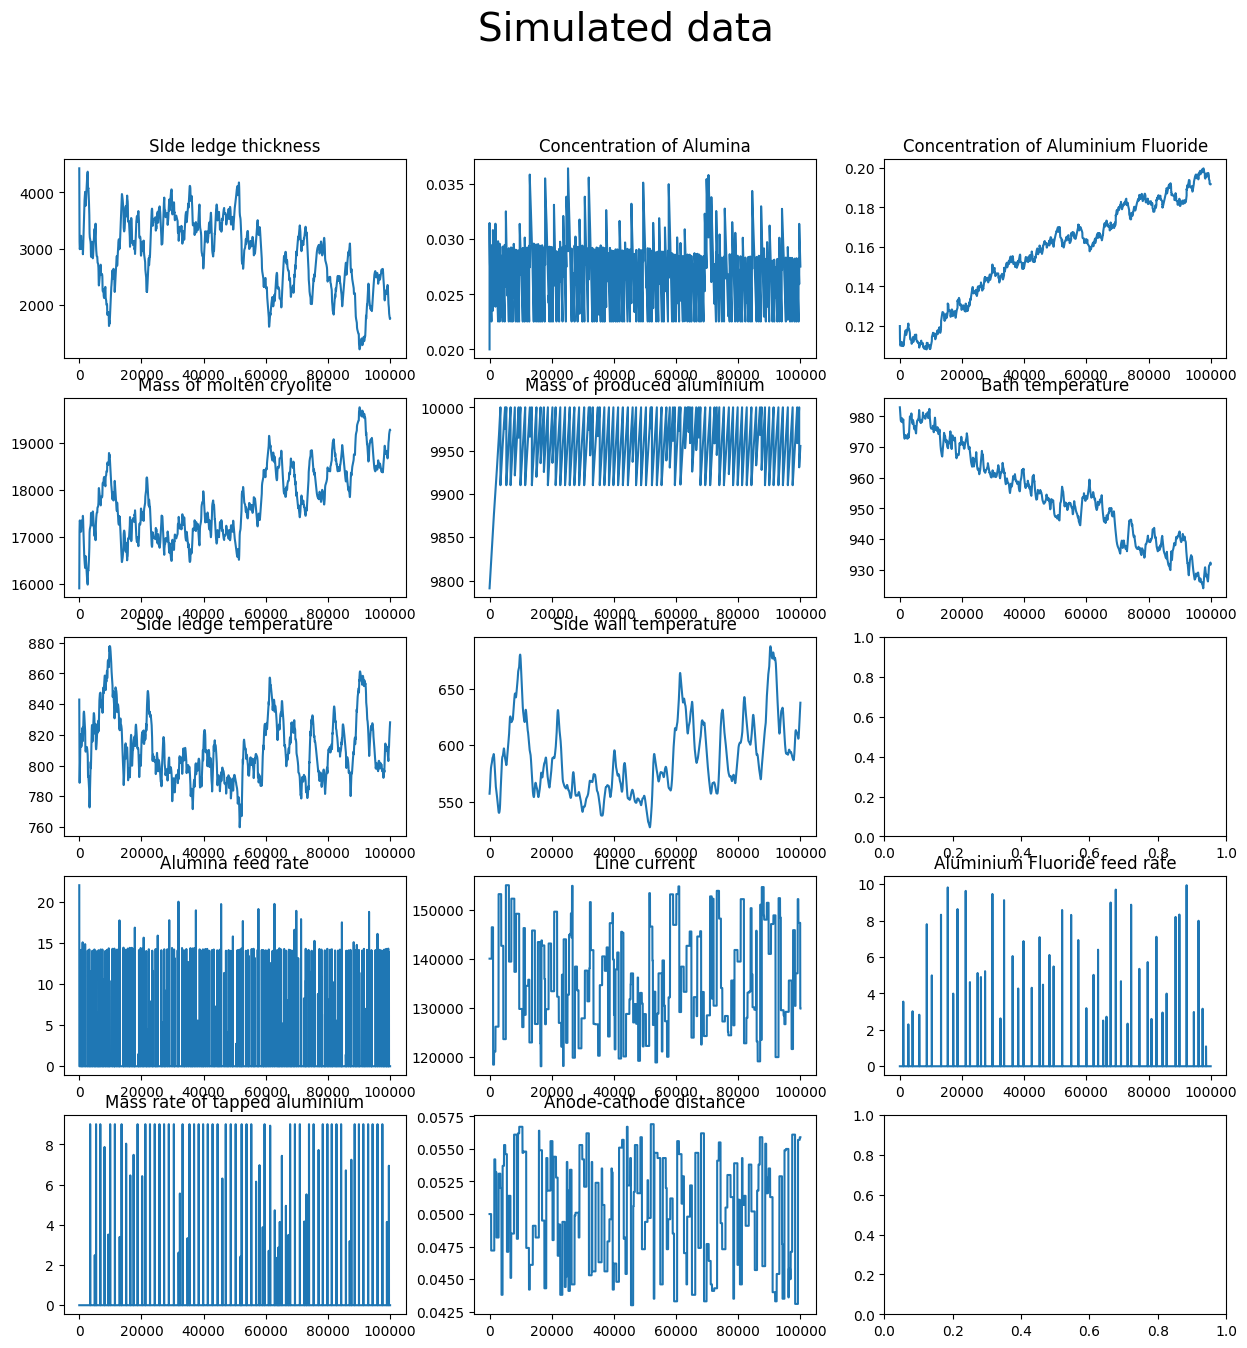

In [15]:

a = 0
b = 100000
sim_num = 2
fig,ax = plt.subplots(5,3,figsize=(15,15))
fig.suptitle('Simulated data' ,fontsize=28)
#fig.suptitle('Simulated data %i' %(sim_num+1),fontsize=28)
for sim_num in range(0,1):
    ax[0,0].plot(data[sim_num,a:b,0]) 
    ax[0,0].set_title('SIde ledge thickness')
    ax[0,1].plot(data[sim_num,a:b,1]/(data[sim_num,a:b,2] + data[sim_num,a:b,1] + data[sim_num,a:b,3])) #X_3d[:,1,sim_num]
    ax[0,1].set_title('Concentration of Alumina')
    ax[0,2].plot(data[sim_num,a:b,2]/(data[sim_num,a:b,2] + data[sim_num,a:b,1] + data[sim_num,a:b,3])) #X_3d[:,2,sim_num]
    ax[0,2].set_title('Concentration of Aluminium Fluoride')
    ax[1,0].plot(data[sim_num,a:b,3])
    ax[1,0].set_title('Mass of molten cryolite')
    ax[1,1].plot(data[sim_num,a:b,4])
    ax[1,1].set_title('Mass of produced aluminium')
    ax[1,2].plot(data[sim_num,a:b,5])
    ax[1,2].set_title('Bath temperature')
    ax[2,0].plot(data[sim_num,a:b,6])
    ax[2,0].set_title('Side ledge temperature')
    ax[2,1].plot(data[sim_num,a:b,7])
    ax[2,1].set_title('Side wall temperature')
    ax[3,0].plot(data[sim_num,a:b,8])
    ax[3,0].set_title('Alumina feed rate')
    ax[3,1].plot(data[sim_num,a:b,9])
    ax[3,1].set_title('Line current')
    ax[3,2].plot(data[sim_num,a:b,10])
    ax[3,2].set_title('Aluminium Fluoride feed rate')
    ax[4,0].plot(data[sim_num,a:b,11])
    ax[4,0].set_title('Mass rate of tapped aluminium')
    ax[4,1].plot(data[sim_num,a:b,12])
    ax[4,1].set_title('Anode-cathode distance')
plt.show()